## Семинар: "Методы оптимизации"

In [28]:
from functools import partial

import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
import ffmpeg
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [10]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

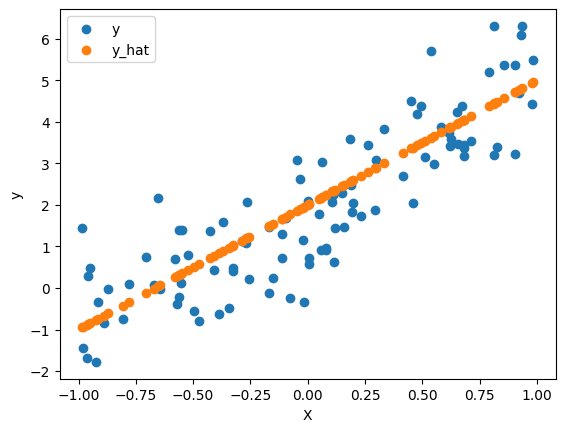

In [11]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

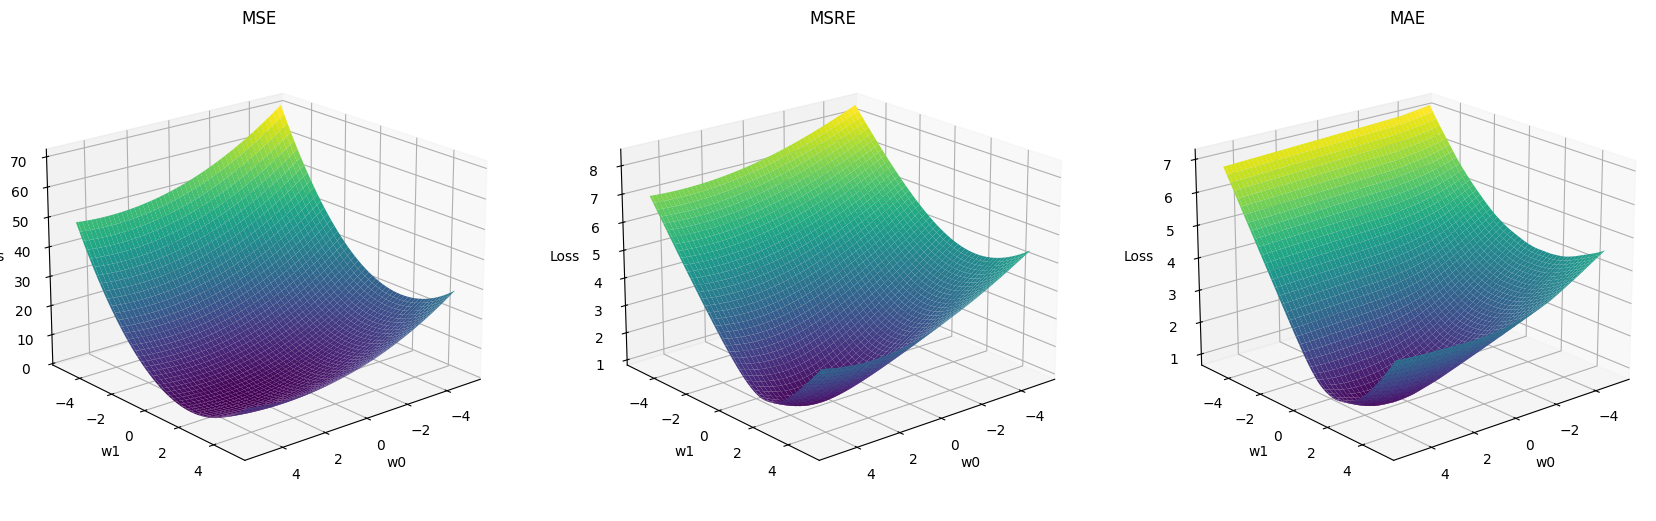

In [12]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [13]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [14]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [15]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [ ]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [17]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [18]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [19]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [21]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [22]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [23]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [27]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

100%|██████████| 9.91M/9.91M [00:23<00:00, 431kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 143kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 240kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [37]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer
        self.epoch = 0

    def step(self):
        self.epoch += 1
        self.update_lr()

    def update_lr(self):
        raise NotImplementedError()

    def get_lr(self):
        return [param_group.get('lr', self.optimizer.lr) for param_group in self.optimizer.param_groups]

In [56]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.base_lr = optimizer.lr

    def update_lr(self):
        if self.epoch < self.total_iters:
            multiplier = self.start_factor + (self.end_factor - self.start_factor) * self.epoch / self.total_iters
            self.optimizer.lr = self.base_lr * multiplier

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.base_lr = optimizer.lr

    def update_lr(self):
        if self.epoch < self.T_max:
            lr = self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1 + np.cos(np.pi * self.epoch / self.T_max))
            self.optimizer.lr = lr

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)  
        self.conv2 = nn.Conv2d(16, 32, 3, 1) 
        self.pool = nn.MaxPool2d(2)          
        self.fc1 = nn.Linear(32 * 12 * 12, 64)  
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [58]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                grad = p.grad
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)


In [ ]:
class AdamW(Optimizer):
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.01):
        super().__init__(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.t = 0
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                p -= self.lr * self.weight_decay * p

                grad = p.grad
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

In [ ]:
def train_simple(optimizer_class, optimizer_args, use_scheduler=None, scheduler_args=None, epochs=8):
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_args)
    
    scheduler = None
    if use_scheduler == 'linear':
        scheduler = LinearLR(optimizer, **scheduler_args)
    elif use_scheduler == 'cosine':
        scheduler = CosineAnnealing(optimizer, **scheduler_args)
    
    train_losses = []
    test_accuracies = []
    learning_rates = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if scheduler:
            scheduler.step()
        learning_rates.append(optimizer.lr)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                pred = output.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += target.size(0)
        
        test_acc = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        test_accuracies.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, LR: {optimizer.lr:.6f}, Loss: {avg_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    return train_losses, test_accuracies, learning_rates


In [ ]:
print("=== Быстрое сравнение оптимизаторов ===")

configs = [
    ('SGD', SGD, {'lr': 0.01}, None, None),
    ('Adam', Adam, {'lr': 0.001}, None, None),
    ('Adam + LinearLR', Adam, {'lr': 0.001}, 'linear', {'start_factor': 0.1, 'end_factor': 1.0, 'total_iters': 5}),
    ('AdamW', AdamW, {'lr': 0.001, 'weight_decay': 0.01}, None, None),
]

results = {}

for name, opt_class, opt_args, scheduler_type, scheduler_args in configs:
    print(f"\n--- {name} ---")
    train_loss, test_acc, lrs = train_simple(opt_class, opt_args, scheduler_type, scheduler_args, epochs=8)
    results[name] = {
        'train_loss': train_loss,
        'test_acc': test_acc,
        'lrs': lrs
    }

=== Быстрое сравнение оптимизаторов ===

--- SGD ---
Epoch 1/8, LR: 0.010000, Loss: 2.2733, Test Acc: 36.00%
Epoch 2/8, LR: 0.010000, Loss: 2.1606, Test Acc: 51.00%
Epoch 3/8, LR: 0.010000, Loss: 1.9113, Test Acc: 52.00%
Epoch 4/8, LR: 0.010000, Loss: 1.4118, Test Acc: 67.00%
Epoch 5/8, LR: 0.010000, Loss: 0.9011, Test Acc: 74.00%
Epoch 6/8, LR: 0.010000, Loss: 0.6220, Test Acc: 80.00%
Epoch 7/8, LR: 0.010000, Loss: 0.5116, Test Acc: 77.00%
Epoch 8/8, LR: 0.010000, Loss: 0.4375, Test Acc: 77.00%

--- Adam ---
Epoch 1/8, LR: 0.001000, Loss: 1.9742, Test Acc: 57.00%
Epoch 2/8, LR: 0.001000, Loss: 0.7474, Test Acc: 70.00%
Epoch 3/8, LR: 0.001000, Loss: 0.4350, Test Acc: 78.00%
Epoch 4/8, LR: 0.001000, Loss: 0.2158, Test Acc: 84.00%
Epoch 5/8, LR: 0.001000, Loss: 0.1084, Test Acc: 79.00%
Epoch 6/8, LR: 0.001000, Loss: 0.0481, Test Acc: 83.00%
Epoch 7/8, LR: 0.001000, Loss: 0.0255, Test Acc: 82.00%
Epoch 8/8, LR: 0.001000, Loss: 0.0091, Test Acc: 80.00%

--- Adam + LinearLR ---
Epoch 1/8, L

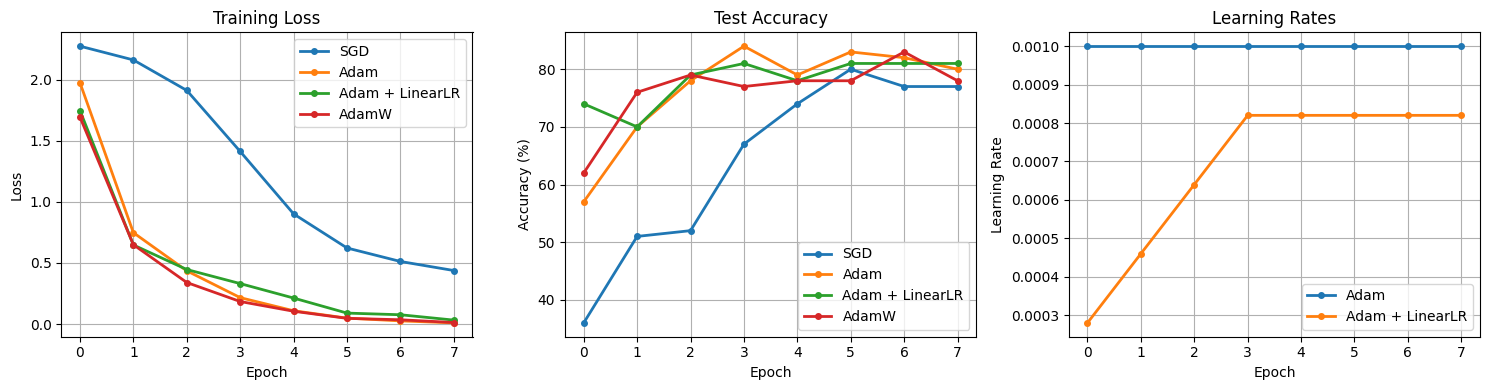


 результаты
Optimizer		Final Test Acc	Best Test Acc
--------------------------------------------------
SGD                     77.00%    80.00%
Adam                    80.00%    84.00%
Adam + LinearLR         81.00%    81.00%
AdamW                   78.00%    83.00%


In [63]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
for name in results:
    plt.plot(results[name]['train_loss'], label=name, linewidth=2, marker='o', markersize=4)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
for name in results:
    plt.plot(results[name]['test_acc'], label=name, linewidth=2, marker='o', markersize=4)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
for name in results:
    if 'LinearLR' in name:
        plt.plot(results[name]['lrs'], label=name, linewidth=2, marker='o', markersize=4)
    elif name == 'Adam': 
        plt.plot(results[name]['lrs'], label=name, linewidth=2, marker='o', markersize=4)
plt.title('Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n результаты")
print("Optimizer\t\tFinal Test Acc\tBest Test Acc")
print("-" * 50)
for name in results:
    final_acc = results[name]['test_acc'][-1]
    best_acc = max(results[name]['test_acc'])
    print(f"{name:20} {final_acc:8.2f}% {best_acc:8.2f}%")

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here